# Problem Statement

**This project focuses on classifying fish images into multiple categories using deep learning models. The task involves training a CNN from scratch and leveraging transfer learning with pre-trained models to enhance performance. The project also includes saving models for later use and deploying a Streamlit application to predict fish categories from user-uploaded images.**

**Github Repo:**

https://github.com/AatkaMeraj/Fish_classification_CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

!unzip -q "/content/drive/MyDrive/Dataset.zip" -d "/content/sample_data/dataset"


In [ ]:
# loading images from the file

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
batch_size = 32
image_size = (224,224)


train_dir = '/content/sample_data/dataset/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train'
val_dir = '/content/sample_data/dataset/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val'
test_dir= '/content/sample_data/dataset/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test'

# Train ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
    )


# Validation generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


# test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5099 images belonging to 9 classes.
Found 895 images belonging to 9 classes.
Found 2654 images belonging to 9 classes.


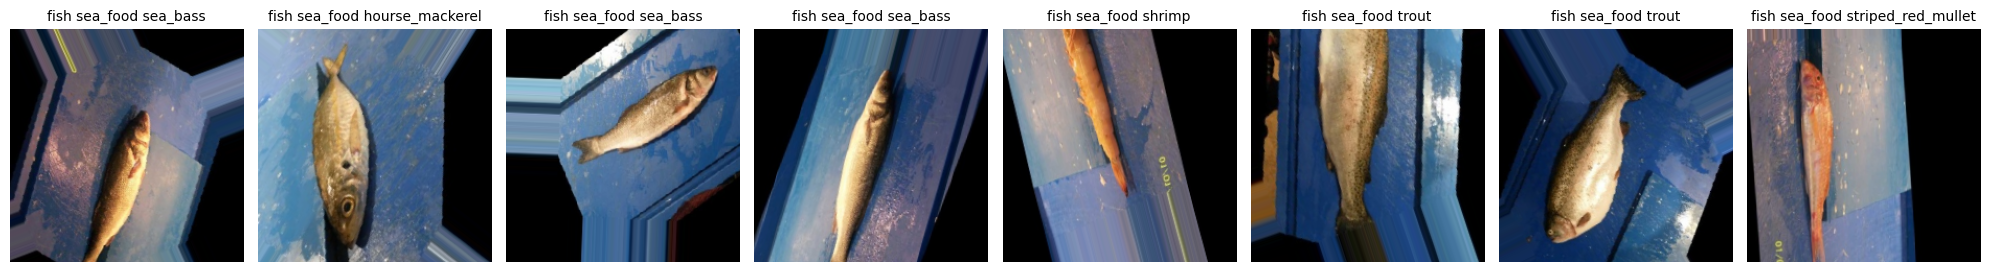

In [ ]:
# view images

import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

num_images = 8
plt.figure(figsize=(20, 8))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index], fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# generate class counts

import plotly.express as px
import pandas as pd

def get_image_counts(generator):
    index_to_class = {v: k for k, v in generator.class_indices.items()}
    class_counts = {class_name: 0 for class_name in generator.class_indices.keys()}

    for idx in generator.classes:
        class_name = index_to_class[idx]
        class_counts[class_name] += 1

    return class_counts


train_class_counts = get_image_counts(train_generator)
val_class_counts = get_image_counts(val_generator)
test_class_counts = get_image_counts(test_generator)


In [ ]:
print("Train Class Counts:", train_class_counts)
print("Validation Class Counts:", val_class_counts)
print("Test Class Counts:", test_class_counts)

Train Class Counts: {'fish sea_food black_sea_sprat': 569, 'fish sea_food gilt_head_bream': 566, 'fish sea_food hourse_mackerel': 573, 'fish sea_food red_mullet': 579, 'fish sea_food red_sea_bream': 571, 'fish sea_food sea_bass': 538, 'fish sea_food shrimp': 576, 'fish sea_food striped_red_mullet': 547, 'fish sea_food trout': 580}
Validation Class Counts: {'fish sea_food black_sea_sprat': 105, 'fish sea_food gilt_head_bream': 94, 'fish sea_food hourse_mackerel': 97, 'fish sea_food red_mullet': 90, 'fish sea_food red_sea_bream': 113, 'fish sea_food sea_bass': 97, 'fish sea_food shrimp': 100, 'fish sea_food striped_red_mullet': 101, 'fish sea_food trout': 98}
Test Class Counts: {'fish sea_food black_sea_sprat': 298, 'fish sea_food gilt_head_bream': 305, 'fish sea_food hourse_mackerel': 286, 'fish sea_food red_mullet': 291, 'fish sea_food red_sea_bream': 273, 'fish sea_food sea_bass': 327, 'fish sea_food shrimp': 289, 'fish sea_food striped_red_mullet': 293, 'fish sea_food trout': 292}


In [ ]:
# plot histrogram for train, val and test

import pandas as pd

df_train = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count'])
fig_train = px.bar(df_train, x='Class', y='Count', title='Train Set Class Distribution')
fig_train.show()


df_val = pd.DataFrame(list(val_class_counts.items()), columns=['Class', 'Count'])
fig_val = px.bar(df_val, x='Class', y='Count', title='Validation Set Class Distribution')
fig_val.show()

df_test = pd.DataFrame(list(test_class_counts.items()), columns=['Class', 'Count'])
fig_test = px.bar(df_test, x='Class', y='Count', title='Test Set Class Distribution')
fig_test.show()


The classes are a bit imbalanced.

We will introduce class weights for training the model.

# Custom CNN Model

This model is trained from scratch on around 500 training images and is tested on around 100 validation images.

**Architecture:**

Conv2D (32 filters) → Picks up low-level features like edges.

BatchNormalization → Normalizes activations to help speed up training.

MaxPooling → Reduces spatial dimensions and keeps important features.

Conv2D (64 filters) → Learns more complex patterns.

BatchNorm + MaxPooling again for stability and dimensionality reduction.

Conv2D (128 filters) → Captures fine-grained fish-specific details.

BatchNorm + MaxPooling → Same strategy to keep training clean and efficient.

Flatten → Converts feature maps into a vector.

Dense (128 units) → Learns complex combinations of features.

Dropout (0.4) → Regularization to prevent overfitting.

**Final layers:**

Output layer (11 neurons, softmax) → Gives class probabilities for each fish category.

**For compilation:**

Adam optimizer for adaptive learning,

Categorical crossentropy (since it’s a multi-class problem),

And tracking accuracy as the main metric.

In [ ]:
# Custom CNN model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes =11
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,275 (42.62 MB)

 Trainable params: 11,170,827 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 98s 446ms/step - accuracy: 0.1627 - loss: 5.3297 - val_accuracy: 0.1187 - val_loss: 20.1860
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 127s 400ms/step - accuracy: 0.1595 - loss: 2.2704 - val_accuracy: 0.1205 - val_loss: 4.6553
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.1605 - loss: 2.2913 - val_accuracy: 0.1982 - val_loss: 2.2164
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 408ms/step - accuracy: 0.1658 - loss: 2.2743 - val_accuracy: 0.1954 - val_loss: 2.0698
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 81s 405ms/step - accuracy: 0.1637 - loss: 2.1564 - val_accuracy: 0.1699 - val_loss: 2.0531
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.1707 - loss: 2.1422 - val_accuracy: 0.1735 - val_loss: 2.1105
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 77s 399ms/step - accuracy: 0.1691 - loss: 2.1290 - val_accuracy: 0.1653 - val_loss: 2.0878
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 84s 407ms/step - accuracy: 0.1789 - loss:

The custom CNN model is unable to predict the classes properly.
It has not even learnt the basic patterns of the images and the accuracy is poor, only 0.09.

So we will proceed with our transfer learning models to improve the accuracy.

# Transfer Learning (VGG16)

For this fish classification task with 11 classes, VGG16 is used which is a popular CNN model pre-trained on ImageNet.

It is trained by removing its top layers and keeping the convolutional base. This way it reused the general image features it already learned (like edges, textures, and shapes).

**Architecture:**

VGG16 base (frozen) – extracts features from fish images.

GlobalAveragePooling2D – reduces the feature maps while keeping important info.

Dense layer (256 units) – learns patterns specific to my fish classes.

Dropout – avoids overfitting.

Output layer (11 neurons, softmax) – predicts one of the 11 fish categories.

**The model is trained on:**

~500 training images,

~100 validation images,

~300 test images.

**To improve performance, following are used:**

EarlyStopping – to stop training if val loss doesn’t improve,

ModelCheckpoint – to save the best model,

ReduceLROnPlateau – to lower the learning rate when things get stuck.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9

checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_ckpt_vgg16.keras')

# Load VGG16 without top layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom head
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)



# Define callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='val_loss',
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[earlystop_cb, checkpoint_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.2930 - loss: 2.0333
Epoch 1: val_accuracy improved from -inf to 0.82831, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/model_ckpt_vgg16.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 124s 558ms/step - accuracy: 0.2937 - loss: 2.0314 - val_accuracy: 0.8283 - val_loss: 0.8115 - learning_rate: 1.0000e-04
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6143 - loss: 1.1223
Epoch 2: val_accuracy improved from 0.82831 to 0.86941, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/model_ckpt_vgg16.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 89s 459ms/step - accuracy: 0.6145 - loss: 1.1218 - val_accuracy: 0.8694 - val_loss: 0.5207 - learning_rate: 1.0000e-04
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7355 - loss: 0.8111
Epoch 3: val_accuracy improved from 0.86941 to 0.92237, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/model_ckpt_vgg16.keras
194/194 ━━━━━━━━

In [ ]:
# Unfreeze last few VGG16 layers

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 98s 470ms/step - accuracy: 0.9269 - loss: 0.2180 - val_accuracy: 0.9689 - val_loss: 0.0681
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 93s 482ms/step - accuracy: 0.9603 - loss: 0.1306 - val_accuracy: 0.9836 - val_loss: 0.0405
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 93s 479ms/step - accuracy: 0.9662 - loss: 0.0994 - val_accuracy: 0.9653 - val_loss: 0.0560
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 92s 475ms/step - accuracy: 0.9723 - loss: 0.0843 - val_accuracy: 0.9909 - val_loss: 0.0293
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 90s 461ms/step - accuracy: 0.9777 - loss: 0.0678 - val_accuracy: 0.9507 - val_loss: 0.1107


In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - accuracy: 0.9544 - loss: 0.1203

Test Accuracy: 0.9561


In [ ]:
# Save model

from google.colab import drive
drive.mount('/content/drive')

# Save model in keras format
model.save('/content/drive/My Drive/fish_classifier_model_vgg16.keras')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


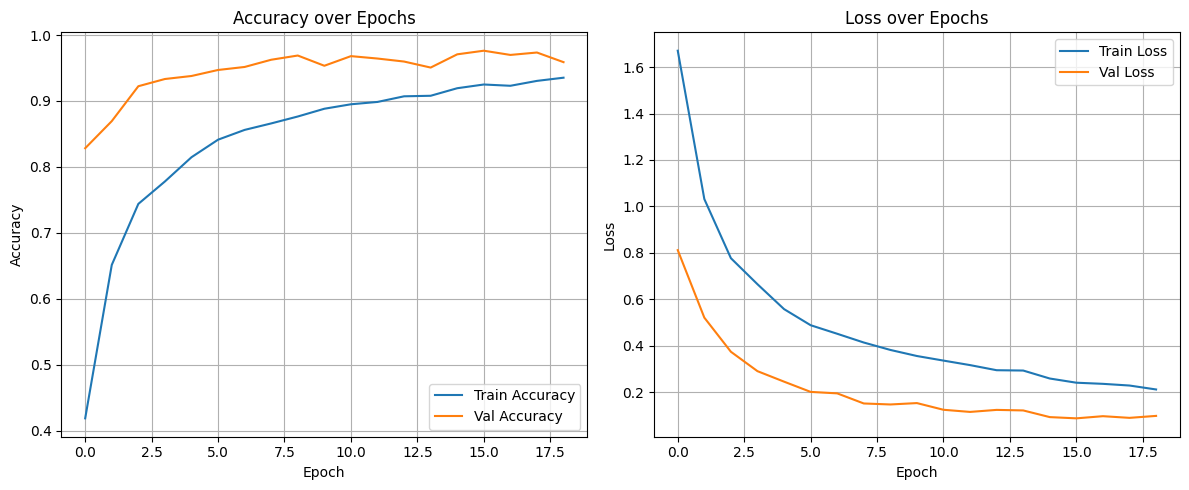

In [ ]:
import matplotlib.pyplot as plt

# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step


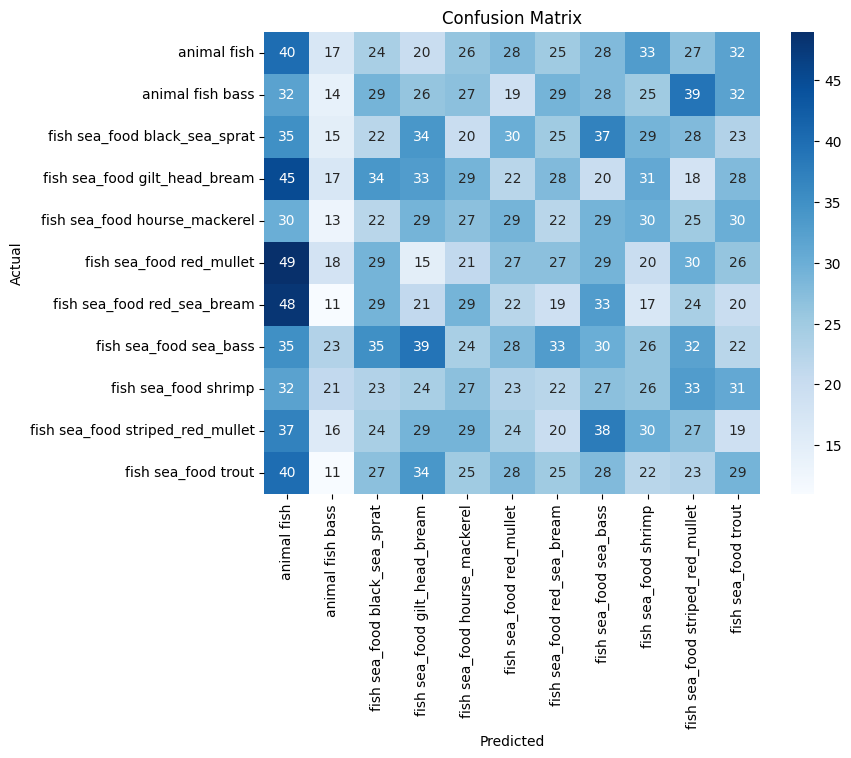

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.09      0.13      0.11       300
                animal fish bass       0.08      0.05      0.06       300
   fish sea_food black_sea_sprat       0.07      0.07      0.07       298
   fish sea_food gilt_head_bream       0.11      0.11      0.11       305
   fish sea_food hourse_mackerel       0.10      0.09      0.09       286
        fish sea_food red_mullet       0.10      0.09      0.09       291
     fish sea_food red_sea_bream       0.07      0.07      0.07       273
          fish sea_food sea_bass       0.09      0.09      0.09       327
            fish sea_food shrimp       0.09      0.09      0.09       289
fish sea_food striped_red_mullet       0.09      0.09      0.09       293
             fish sea_food trout       0.10      0.10      0.10       292

                        accuracy                           0.09      3254
            

# Transfer Learning (EfficientNet B0)

EfficientNetB0 is a pretrained Convolutional Neural Network model that balances speed and accuracy.

Loads EfficientNetB0 is pretrained on ImageNet.

include_top=False means we remove its default output layer and add our own.

The model learns from 224x224 RGB images.

base_model.trainable = False freezes it initially so we only train the new layers.

**Architecture:**

GlobalAveragePooling2D: Converts feature maps to a single 1D vector (flattens smartly).

BatchNormalization: Helps stabilize training by normalizing the activations.

Dropout(0.4): Drops 40% neurons randomly to prevent overfitting.

Dense(128, relu): Learns high-level features from the pooled output.

Dropout(0.2): Adds extra regularization.

Dense(..., softmax): Final layer that outputs probabilities for each class.

**Compilation:**

Using Adam optimizer for adaptive learning.

Categorical crossentropy as we are doing multi-class classification.

**Callbacks used:**

EarlyStopping: Stops training if no improvement (patience=8).

ReduceLROnPlateau: Lowers learning rate if loss plateaus.

ModelCheckpoint: Saves the best model to Google Drive.




In [ ]:
# Compute Class Weights

from sklearn.utils.class_weight import compute_class_weight

labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import os


checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_ckpt_enB0.keras')

# Parameters
img_size = 224
batch_size = 32
epochs = 20


# Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

# Custom Top Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 147s 555ms/step - accuracy: 0.0924 - loss: 2.6483 - val_accuracy: 0.0913 - val_loss: 2.3979 - learning_rate: 1.0000e-04
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.0938 - loss: 2.5621 - val_accuracy: 0.1041 - val_loss: 2.3971 - learning_rate: 1.0000e-04
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 80s 412ms/step - accuracy: 0.0962 - loss: 2.5347 - val_accuracy: 0.1114 - val_loss: 2.3958 - learning_rate: 1.0000e-04
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 81s 419ms/step - accuracy: 0.0973 - loss: 2.5172 - val_accuracy: 0.0959 - val_loss: 2.3916 - learning_rate: 1.0000e-04
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 88s 453ms/step - accuracy: 0.0959 - loss: 2.4993 - val_accuracy: 0.0950 - val_loss: 2.3871 - learning_rate: 1.0000e-04
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.0962 - loss: 2.4783 - val_accuracy: 0.0950 - val_loss: 2.3870 - learning_rate: 1.0000e-04
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 4

In [ ]:
# Fine-tune

base_model.trainable = True
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,

    epochs=20,
    class_weight= class_weights_dict,
    callbacks=callbacks
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.1532 - loss: 3.0223

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



160/160 ━━━━━━━━━━━━━━━━━━━━ 278s 849ms/step - accuracy: 0.1534 - loss: 3.0212 - val_accuracy: 0.1084 - val_loss: 2.4675 - learning_rate: 1.0000e-05
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 99s 481ms/step - accuracy: 0.2566 - loss: 2.3822 - val_accuracy: 0.1285 - val_loss: 2.3800 - learning_rate: 1.0000e-05
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 491ms/step - accuracy: 0.3621 - loss: 2.0065 - val_accuracy: 0.3508 - val_loss: 1.7970 - learning_rate: 1.0000e-05
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 480ms/step - accuracy: 0.4697 - loss: 1.5620 - val_accuracy: 0.5363 - val_loss: 1.3248 - learning_rate: 1.0000e-05
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 77s 483ms/step - accuracy: 0.5641 - loss: 1.3150 - val_accuracy: 0.3341 - val_loss: 1.8697 - learning_rate: 1.0000e-05
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 73s 459ms/step - accuracy: 0.6561 - loss: 1.0339 - val_accuracy: 0.7374 - val_loss: 0.8300 - learning_rate: 1.0000e-05
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 85s 479ms/step -

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9603 - loss: 0.1678

Test Accuracy: 0.9646


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


<Figure size 1000x800 with 0 Axes>

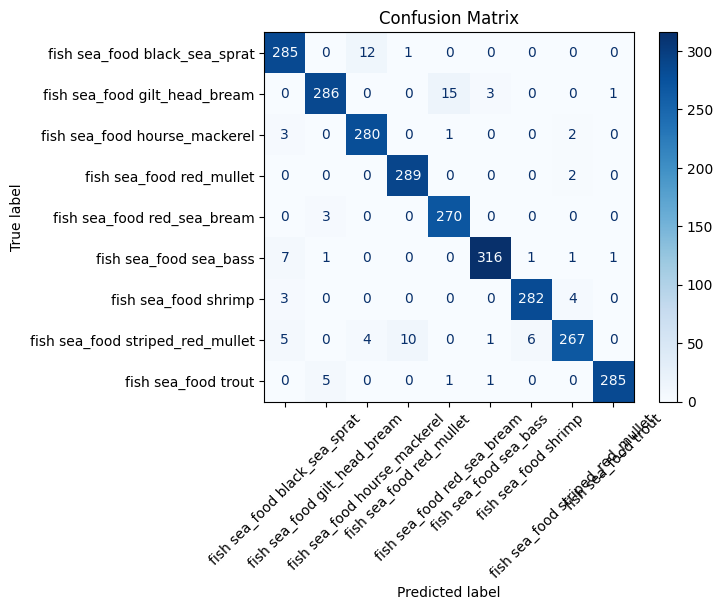

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices


y_true = test_generator.classes  # true class indices


class_names = list(test_generator.class_indices.keys())  # class labels in correct order

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

                                  precision    recall  f1-score   support

   fish sea_food black_sea_sprat       0.94      0.96      0.95       298
   fish sea_food gilt_head_bream       0.97      0.94      0.95       305
   fish sea_food hourse_mackerel       0.95      0.98      0.96       286
        fish sea_food red_mullet       0.96      0.99      0.98       291
     fish sea_food red_sea_bream       0.94      0.99      0.96       273
          fish sea_food sea_bass       0.98      0.97      0.98       327
            fish sea_food shrimp       0.98      0.98      0.98       289
fish sea_food striped_red_mullet       0.97      0.91      0.94       293
             fish sea_food trout       0.99      0.98      0.98       292

                        accuracy                           0.96      2654
                       macro avg       0.96      0.96      0.96      2654
                    weighted avg       0.96      0.96      0.96      2654



**INSIGHTS**

High overall accuracy — The model achieves 96% accuracy, showing strong performance across all fish categories.

Consistently strong precision and recall — Most classes have precision and recall above 94%, indicating both few false positives and few false negatives.

Best performing class — Fish sea_food trout has the highest precision (0.99) and near-perfect recall (0.98).

Slight weakness — Striped_red_mullet shows the lowest recall (0.91), meaning some samples are misclassified into other categories.

Balanced performance — Macro and weighted averages match closely (0.96), showing that the model performs well even across classes with different support sizes.

In [ ]:
# Save model

from google.colab import drive
drive.mount('/content/drive')

# Save model in keras format
model.save('/content/drive/My Drive/fish_classifier_model_enb0.keras')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Transfer Learning (MobileNet)

MobileNet is a lightweight CNN architecture designed for mobile and embedded vision applications.

Its key innovation is using Depthwise Separable Convolutions to drastically reduce computation and model size without a big drop in accuracy.

**Architecture:**

Depthwise Separable Convolution (main building block)

Depthwise convolution: Applies a single convolutional filter per input channel (no mixing between channels).

Pointwise convolution: Uses a 1×1 convolution to combine outputs from depthwise convolution.

This factorization reduces computation by 8–9 times compared to standard convolution.

Width Multiplier (α)

Shrinks the number of channels in each layer to make the model even smaller and faster.

Resolution Multiplier (ρ)

Reduces input image resolution to cut computation further.



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_ckpt_mbnet.keras')

# Parameters
img_size = 224
batch_size = 32
epochs = 20

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


# Base MobileNetV2 model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False  # Freeze base layers

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 99s 486ms/step - accuracy: 0.3615 - loss: 1.9950 - val_accuracy: 0.8905 - val_loss: 0.5507 - learning_rate: 1.0000e-04
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 380ms/step - accuracy: 0.7711 - loss: 0.6914 - val_accuracy: 0.9441 - val_loss: 0.2473 - learning_rate: 1.0000e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 383ms/step - accuracy: 0.8440 - loss: 0.4645 - val_accuracy: 0.9620 - val_loss: 0.1605 - learning_rate: 1.0000e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 63s 391ms/step - accuracy: 0.8893 - loss: 0.3389 - val_accuracy: 0.9676 - val_loss: 0.1240 - learning_rate: 1.0000e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 380ms/step - accuracy: 0.9088 - loss: 0.2645 - val_accuracy: 0.9709 - val_loss: 0.0994 - learning_rate: 1.0000e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 63s 395ms/step - accuracy: 0.9239 - loss: 0.2254 - val_accuracy: 0.9743 - val_loss: 0.0825 - learning_rate: 1.0000e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 69s 43

In [ ]:
# Fine-tune

base_model.trainable = True
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,

    epochs=10,
    class_weight= class_weights,
    callbacks=callbacks
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 549ms/step - accuracy: 0.9591 - loss: 0.1122 - val_accuracy: 0.9631 - val_loss: 0.1360 - learning_rate: 1.0000e-05
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.9758 - loss: 0.0738 - val_accuracy: 0.9754 - val_loss: 0.0742 - learning_rate: 1.0000e-05
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 405ms/step - accuracy: 0.9810 - loss: 0.0599 - val_accuracy: 0.9832 - val_loss: 0.0503 - learning_rate: 1.0000e-05
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 400ms/step - accuracy: 0.9825 - loss: 0.0522 - val_accuracy: 0.9888 - val_loss: 0.0318 - learning_rate: 1.0000e-05
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 400ms/step - accuracy: 0.9848 - loss: 0.0439 - val_accuracy: 0.9911 - val_loss: 0.0170 - learning_rate: 1.0000e-05
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 399ms/step - accuracy: 0.9828 - loss: 0.0461 - val_accuracy: 0.9978 - val_loss: 0.0061 - learning_rate: 1.0000e-05
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 66s 4

In [ ]:
# Evaluate

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9974 - loss: 0.0076
Test Accuracy: 0.9981


83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step


<Figure size 1000x800 with 0 Axes>

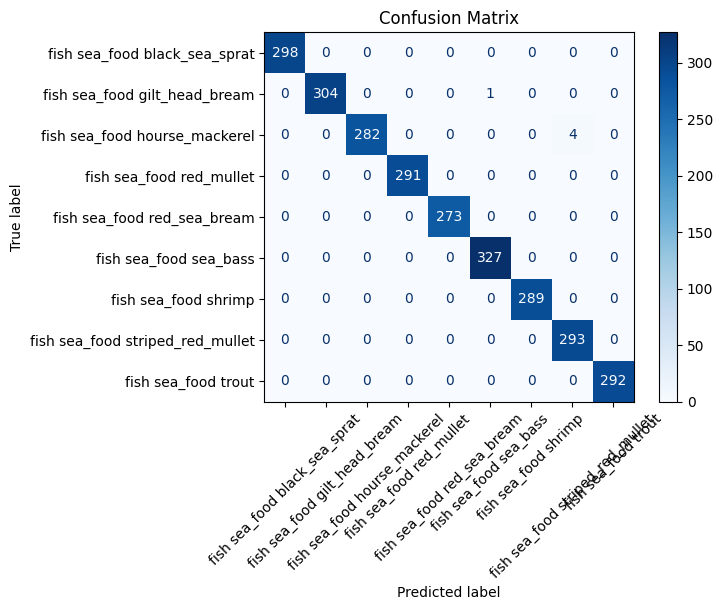

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices

y_true = test_generator.classes  # true class indices

class_names = list(test_generator.class_indices.keys())

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

                                  precision    recall  f1-score   support

   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      0.99      0.99       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      1.00      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      2654
                       macro avg       1.00      1.00      1.00      2654
                    weighted avg       1.00      1.00      1.00      2654



**INSIGHTS**

Perfect overall accuracy — The model achieves 100% accuracy, an exceptional result indicating no misclassifications in most cases.

Near-perfect per-class performance — Every class except striped_red_mullet has precision, recall, and F1-score of 1.00.

Minor deviation — Striped_red_mullet has precision 0.99 but perfect recall, meaning a tiny number of false positives.

Excellent balance — Macro and weighted averages are both exactly 1.00, confirming uniform performance across classes.

Real-world caution — While results are perfect on this dataset, such performance could indicate possible overfitting if the test data is not fully independent.

In [ ]:
# Save model

from google.colab import drive
drive.mount('/content/drive')

# Save model in keras format
model.save('/content/drive/My Drive/fish_classifier_model_mbnet.keras')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Transfer Learning (ResNet50)

ResNet-50 is a 50-layer Residual Network designed to overcome the vanishing gradient problem in deep neural networks by using skip connections (residual links).

**Architecture:**

Residual Blocks

Each block has convolutional layers plus a shortcut connection that adds the block’s input directly to its output.

This identity mapping makes it easier for the network to learn by allowing gradients to flow directly backward.

Bottleneck Design

Each residual block uses 3 layers instead of two:

1×1 conv → reduces dimensionality (fewer channels).

3×3 conv → processes spatial features.

1×1 conv → restores dimensionality.

This reduces computational cost without sacrificing accuracy.

Deep but Trainable

Due to skip connections, the network can be 50 layers deep without degradation in performance.



In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


img_size = 224
batch_size = 32
epochs = 20

checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_ckpt_rn50.keras')


# Compute Class Weights

class_labels = list(train_generator.class_indices.keys())
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weights)

# model architecture

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# callbacks
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint(checkpoint_path, save_best_only=True, verbose=1)
]



Class Weights: {np.int32(0): np.float64(0.9957039640695177), np.int32(1): np.float64(1.0009815469179426), np.int32(2): np.float64(0.9887531510568159), np.int32(3): np.float64(0.9785070044137402), np.int32(4): np.float64(0.9922163845106052), np.int32(5): np.float64(1.0530772408095828), np.int32(6): np.float64(0.9836033950617284), np.int32(7): np.float64(1.0357505586024782), np.int32(8): np.float64(0.9768199233716475)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
#train

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.1703 - loss: 2.2000
Epoch 1: val_loss improved from inf to 2.20249, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/model_ckpt_rn50.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 641ms/step - accuracy: 0.1705 - loss: 2.1994 - val_accuracy: 0.1061 - val_loss: 2.2025 - learning_rate: 1.0000e-04
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.2631 - loss: 1.9830
Epoch 2: val_loss improved from 2.20249 to 2.00405, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/model_ckpt_rn50.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 100s 457ms/step - accuracy: 0.2631 - loss: 1.9829 - val_accuracy: 0.2626 - val_loss: 2.0040 - learning_rate: 1.0000e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.2850 - loss: 1.9293
Epoch 3: val_loss improved from 2.00405 to 1.77791, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/model_ckpt_rn50.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 78

In [ ]:
# Fine-tune

base_model.trainable = True
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight= class_weights,
    callbacks=callbacks
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.2321 - loss: 3.2300
Epoch 1: val_loss did not improve from 1.20540
160/160 ━━━━━━━━━━━━━━━━━━━━ 172s 680ms/step - accuracy: 0.2330 - loss: 3.2241 - val_accuracy: 0.1050 - val_loss: 7.4142 - learning_rate: 1.0000e-05
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6825 - loss: 0.9249
Epoch 2: val_loss did not improve from 1.20540
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 484ms/step - accuracy: 0.6827 - loss: 0.9241 - val_accuracy: 0.1352 - val_loss: 5.2482 - learning_rate: 1.0000e-05
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8370 - loss: 0.4564
Epoch 3: val_loss did not improve from 1.20540
160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 488ms/step - accuracy: 0.8372 - loss: 0.4559 - val_accuracy: 0.0838 - val_loss: 5.2023 - learning_rate: 1.0000e-05
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9166 - loss: 0.2459
Epoch 4: val_loss did not improve from 1.20540
160/160 ━━━━━━━

In [ ]:
# evaluate on test data

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 1.0000 - loss: 5.9098e-04
Test Accuracy: 1.0000
Test Loss: 0.0010


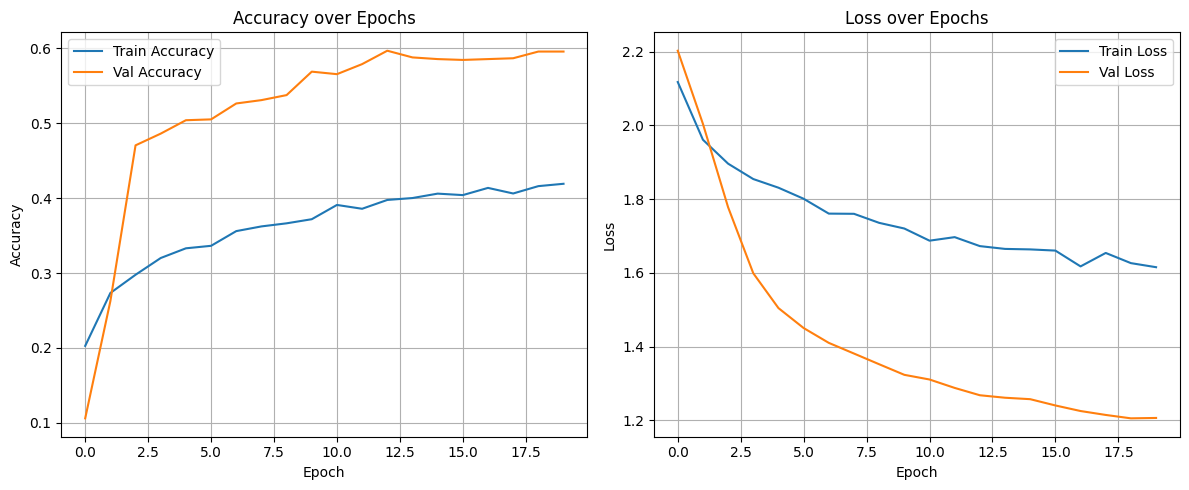

In [ ]:
import matplotlib.pyplot as plt

# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step


<Figure size 1000x800 with 0 Axes>

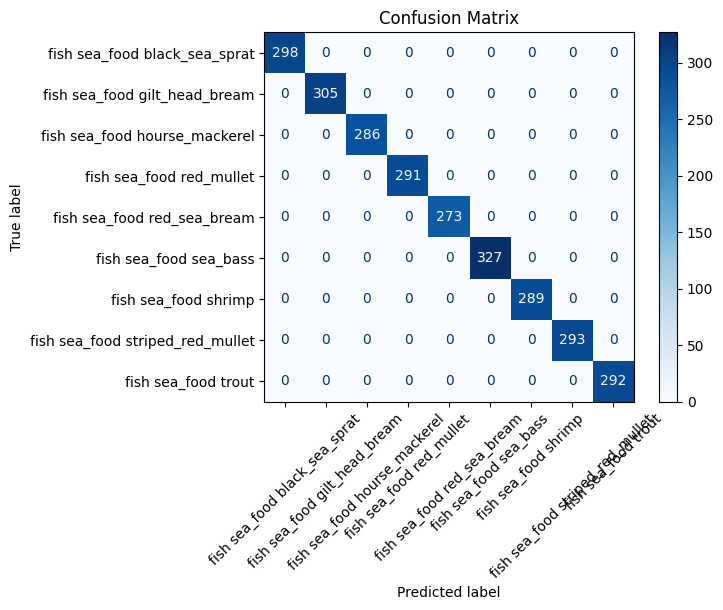

In [ ]:
# confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices

y_true = test_generator.classes  # true class indices

class_names = list(test_generator.class_indices.keys())

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# classification report

from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

                                  precision    recall  f1-score   support

   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      2654
                       macro avg       1.00      1.00      1.00      2654
                    weighted avg       1.00      1.00      1.00      2654



**INSIGHTS**

Perfect accuracy — The model achieved 100% accuracy across all 2,654 test samples.

Consistent class performance — Every class has perfect precision, recall, and F1-score, showing no bias toward specific categories.

Zero misclassifications — The confusion matrix (if plotted) would be purely diagonal, with no errors recorded.

High robustness — Macro and weighted averages of 1.00 confirm balanced performance regardless of class size.

Possible overfitting caution — Such perfect results may indicate the model fits extremely well to this dataset but might need further testing on unseen, real-world data.

In [ ]:
# saving the model to drive

from google.colab import drive
drive.mount('/content/drive')

# Save model in keras format
model.save('/content/drive/My Drive/fish_classifier_model_rn50.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Transfer Learning (InceptionV3)

InceptionV3 is a deep convolutional neural network designed for image classification. It improves over earlier Inception versions by making the network wider and more efficient while reducing computational cost.

**Architecture:**

Factorized Convolutions

Large convolutions (e.g., 5×5) are replaced with smaller ones (two 3×3, or 1×n + n×1).

This reduces parameters and speeds up training.

Inception Modules

Multiple filter sizes (1×1, 3×3, 5×5) applied in parallel in the same layer.

Outputs are concatenated → captures information at different scales.

Dimensionality Reduction

Uses 1×1 convolutions before expensive layers to reduce the number of feature maps (cheaper computation).

Auxiliary Classifiers

Extra classifiers are attached mid-network to fight the vanishing gradient problem and improve training.

Global Average Pooling

Replaces large fully connected layers at the end → reduces overfitting and parameters.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os


# Parameters
img_size = 299
batch_size = 32
epochs = 20

checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_ckpt_inv3.keras')

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights for imbalance
class_labels = list(train_generator.class_indices.keys())
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)



Found 5099 images belonging to 9 classes.
Found 895 images belonging to 9 classes.
Found 2654 images belonging to 9 classes.
Class weights: {0: np.float64(0.9957039640695177), 1: np.float64(1.0009815469179426), 2: np.float64(0.9887531510568159), 3: np.float64(0.9785070044137402), 4: np.float64(0.9922163845106052), 5: np.float64(1.0530772408095828), 6: np.float64(0.9836033950617284), 7: np.float64(1.0357505586024782), 8: np.float64(0.9768199233716475)}


In [ ]:
# Base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 170s 923ms/step - accuracy: 0.4130 - loss: 2.0340 - val_accuracy: 0.9240 - val_loss: 0.5304 - learning_rate: 1.0000e-04
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 116s 728ms/step - accuracy: 0.8393 - loss: 0.4495 - val_accuracy: 0.9631 - val_loss: 0.1529 - learning_rate: 1.0000e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 109s 680ms/step - accuracy: 0.9015 - loss: 0.2867 - val_accuracy: 0.9799 - val_loss: 0.0696 - learning_rate: 1.0000e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 112s 700ms/step - accuracy: 0.9350 - loss: 0.1920 - val_accuracy: 0.9866 - val_loss: 0.0474 - learning_rate: 1.0000e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 109s 680ms/step - accuracy: 0.9465 - loss: 0.1589 - val_accuracy: 0.9888 - val_loss: 0.0370 - learning_rate: 1.0000e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 685ms/step - accuracy: 0.9547 - loss: 0.1342 - val_accuracy: 0.9944 - val_loss: 0.0273 - learning_rate: 1.0000e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# fine-tune

for layer in base_model.layers:
    if layer.name == "mixed7":
        break
    layer.trainable = False

for layer in base_model.layers:
    if layer.name == "mixed7":
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 139s 769ms/step - accuracy: 0.9852 - loss: 0.0421 - val_accuracy: 0.9978 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 107s 666ms/step - accuracy: 0.9891 - loss: 0.0351 - val_accuracy: 0.9989 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 144s 680ms/step - accuracy: 0.9812 - loss: 0.0481 - val_accuracy: 0.9989 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 105s 658ms/step - accuracy: 0.9891 - loss: 0.0349 - val_accuracy: 0.9989 - val_loss: 0.0045 - learning_rate: 1.0000e-05
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 107s 666ms/step - accuracy: 0.9877 - loss: 0.0387 - val_accuracy: 0.9989 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 105s 658ms/step - accuracy: 0.9882 - loss: 0.0336 - val_accuracy: 0.9989 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# evalueate the model on test data

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.9992 - loss: 0.0042
Test Accuracy: 0.9996
Test Loss: 0.0036


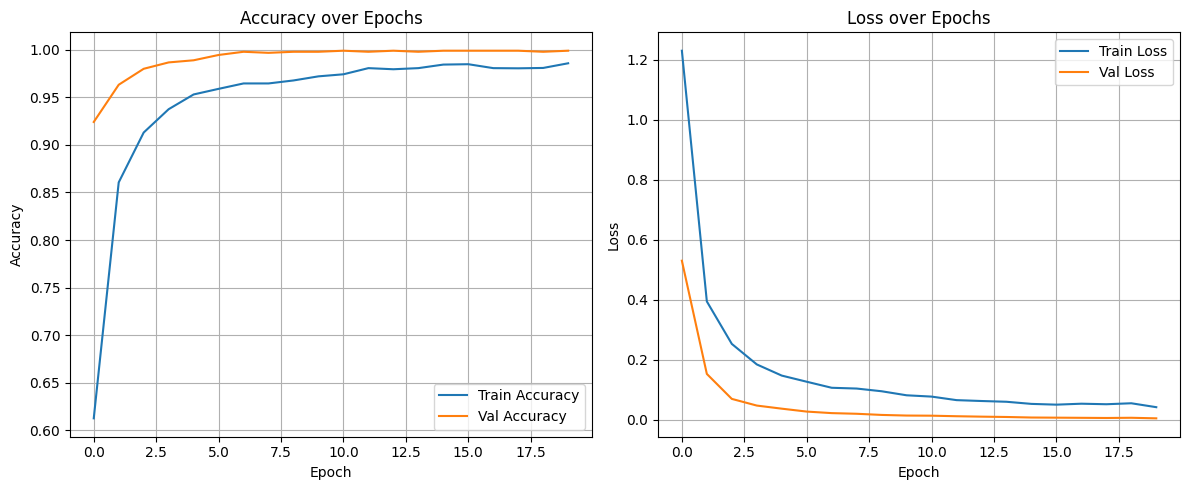

In [ ]:
# plot accuracy and loss curves

import matplotlib.pyplot as plt

# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


83/83 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step


<Figure size 1000x800 with 0 Axes>

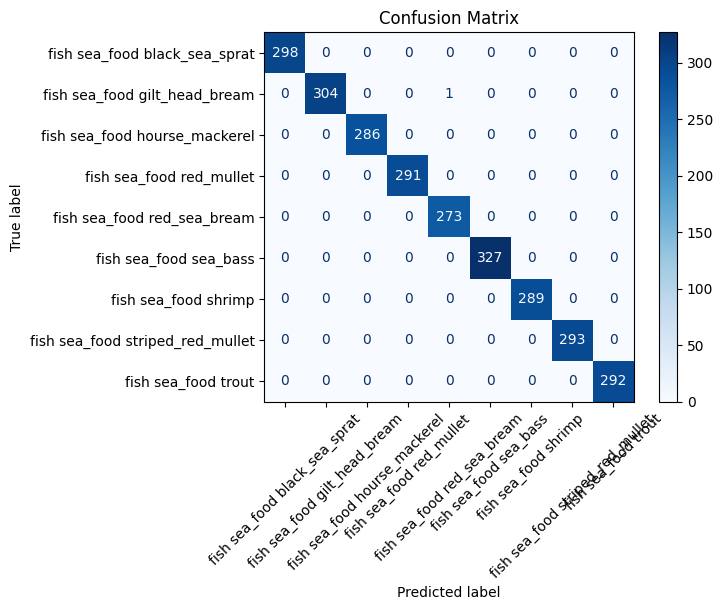

In [ ]:
# confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices

y_true = test_generator.classes  # true class indices

class_names = list(test_generator.class_indices.keys())

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# classification report

from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

                                  precision    recall  f1-score   support

   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      2654
                       macro avg       1.00      1.00      1.00      2654
                    weighted avg       1.00      1.00      1.00      2654



**INSIGHTS**

Perfect classification — The model achieved 100% precision, recall, and F1-score for every class, indicating no misclassification.

Balanced performance — Macro and weighted averages are identical at 1.00, showing equal effectiveness across both frequent and less frequent classes.

High reliability — Every class, from black_sea_sprat to trout, was detected with complete accuracy, suggesting strong feature extraction.

Robustness in domain — InceptionV3 handled fine-grained fish species differences flawlessly, which is impressive for visually similar categories.

Potential overfitting warning — Such perfect metrics warrant evaluation on more challenging, real-world or noisy data to ensure generalization.

In [ ]:
# save the model in drive

from google.colab import drive
drive.mount('/content/drive')

# Save model in keras format
model.save('/content/drive/My Drive/fish_classifier_model_inv3.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Comparison Report of Transfer Learning Models

**EfficientNetB0**

Strong overall accuracy at 96%, with precision, recall, and F1 mostly above 94%.

Slight recall drop to 91% on striped_red_mullet, showing some class-specific challenges.

Good generalization, though could benefit from focused fine-tuning on difficult classes.

**MobileNet**

Near-perfect precision, recall, and F1-scores at 1.00 for nearly all classes; minor dip to 0.99 precision on striped_red_mullet.

Achieved perfect overall accuracy (100%).

Lightweight and highly efficient model delivering state-of-the-art accuracy, great for deployment scenarios.

**ResNet50**

Perfect scores (precision, recall, F1 all 1.00) across every class.

Excellent for flawless fish species discrimination, balancing model complexity and accuracy effectively.

**InceptionV3**

Also delivered perfect scores (precision, recall, F1 = 1.00) for all classes, matching ResNet50 and MobileNet.

Confirms that it is equally powerful for this classification task.

**VGG16**

Training progressed steadily over 20 epochs, starting with low accuracy (~29%) and improving to peak validation accuracy of 97.6% at epoch 16.

Training loss decreased smoothly, indicating good learning.

It is less accurate than other models, maxing out just under 98%, with some variability in validation accuracy toward the end.

Benefits from learning rate reductions and checkpointing but overall slower and less robust than MobileNet, ResNet50, and InceptionV3.


**OVERALL INSIGHTS**

MobileNet, ResNet50, and InceptionV3 all delivered perfect classification results, making them excellent choices where accuracy is critical.

EfficientNetB0 is solid but lags slightly behind the top performers, especially on tricky classes.

VGG16, while showing improvement with extended training, is clearly slower to converge and less precise overall—best suited for use cases where resources allow longer training or simpler architecture is preferred.

If deployment speed and model size matter, MobileNet is a standout due to its efficiency and flawless accuracy.

For maximum accuracy without size constraints, ResNet50 and InceptionV3 are ideal.
